# Colab init

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os
sys.path.append("/content/drive/MyDrive/MLEX3")
%cd /content/drive/MyDrive/MLEX3/

/content/drive/MyDrive/MLEX3


In [3]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.6 MB/s eta 0:00:00


# Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Softmax, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import UniversalPerturbation

# Loading and splitting dataset

In [5]:
def load_dataset(directory, size=(64,64)):
    X, y = [], []
    for folder in os.listdir(directory):
        label = int(folder[1:])  # folders 's1', 's2'...
        folder_path = os.path.join(directory, folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.resize(size) # resize to 64x64
            X.append(np.array(image))
            y.append(label)
    X = np.array(X) / 255.0  # normalize
    y = np.array(y) - 1  # labels start 0, not 1
    return X, y

In [6]:
X, y = load_dataset('data/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reshape((-1, 64, 64, 1))
X_val = X_val.reshape((-1, 64, 64, 1))
X_test = X_test.reshape((-1, 64, 64, 1))

# Build and train model

In [7]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(40, activation='softmax')  # 40 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model = build_model((64, 64, 1))

# instance early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
15/15 [==============================] - 6s 20ms/step - loss: 3.7322 - accuracy: 0.0250 - val_loss: 3.6888 - val_accuracy: 0.0375
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 3.6686 - accuracy: 0.0500 - val_loss: 3.6795 - val_accuracy: 0.0125
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 3.5824 - accuracy: 0.0875 - val_loss: 3.6297 - val_accuracy: 0.0375
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 3.3908 - accuracy: 0.1792 - val_loss: 3.4162 - val_accuracy: 0.2000
Epoch 5/50
15/15 [==============================] - 0s 8ms/step - loss: 2.9273 - accuracy: 0.2833 - val_loss: 2.9910 - val_accuracy: 0.2875
Epoch 6/50
15/15 [==============================] - 0s 8ms/step - loss: 2.2341 - accuracy: 0.4500 - val_loss: 2.2546 - val_accuracy: 0.4750
Epoch 7/50
15/15 [==============================] - 0s 8ms/step - loss: 1.5762 - accuracy: 0.5833 - val_loss: 1.6766 - val_accuracy: 0.6125
Epoch 8/50
15/15 [=

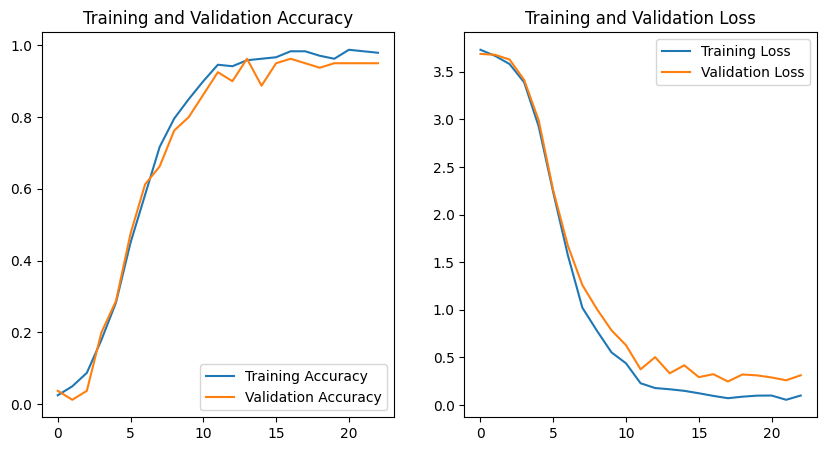

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Defensive distilation

In [10]:
def build_model_dist_teacher(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(40)
    ])
    return model

def softened_softmax(logits, temperature=1):
    soft_max_output = Softmax()(logits / temperature)
    return soft_max_output

def build_model_dist_student(input_shape, use_softmax=True, temperature=1.0):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(40)  # no activation here
    ])

    if use_softmax:
        # softened softmax during training
        model.add(Lambda(lambda x: softened_softmax(x, temperature)))
    else:
        # standard softmax during evaluation
        model.add(Softmax())

    return model


In [11]:
loss_dist = SparseCategoricalCrossentropy(from_logits=True)
teacher_model = build_model_dist_teacher((64, 64, 1))
teacher_model.compile(optimizer='adam', loss=loss_dist, metrics=['accuracy'])
teacher_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# get logits from the teacher model
logits = teacher_model.predict(X_train)
print("Logits Shape:", logits.shape)

Epoch 1/50
15/15 [==============================] - 1s 19ms/step - loss: 3.7086 - accuracy: 0.0250 - val_loss: 3.6860 - val_accuracy: 0.0375
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 3.6443 - accuracy: 0.0875 - val_loss: 3.6805 - val_accuracy: 0.0250
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 3.4793 - accuracy: 0.1167 - val_loss: 3.5402 - val_accuracy: 0.0500
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 3.1242 - accuracy: 0.1833 - val_loss: 3.2662 - val_accuracy: 0.1375
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 2.4932 - accuracy: 0.3958 - val_loss: 2.8186 - val_accuracy: 0.2375
Epoch 6/50
15/15 [==============================] - 0s 7ms/step - loss: 1.7975 - accuracy: 0.5375 - val_loss: 2.1565 - val_accuracy: 0.5375
Epoch 7/50
15/15 [==============================] - 0s 7ms/step - loss: 1.2340 - accuracy: 0.6875 - val_loss: 1.5246 - val_accuracy: 0.6125
Epoch 8/50
15/15 [=

In [12]:
student_labels = softened_softmax(logits, temperature=10)

In [13]:
student_model = build_model_dist_student(input_shape=(64, 64, 1), use_softmax=True, temperature=10)
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
y_val_dist = to_categorical(y_val, num_classes=40)
student_model.fit(
    X_train, student_labels,  
    validation_data=(X_val, y_val_dist),  
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping]
)

Epoch 1/50
15/15 [==============================] - 2s 25ms/step - loss: 3.6864 - accuracy: 0.0333 - val_loss: 3.7066 - val_accuracy: 0.0375
Epoch 2/50
15/15 [==============================] - 0s 12ms/step - loss: 3.6830 - accuracy: 0.0417 - val_loss: 3.7104 - val_accuracy: 0.0375
Epoch 3/50
15/15 [==============================] - 0s 10ms/step - loss: 3.6774 - accuracy: 0.0375 - val_loss: 3.6814 - val_accuracy: 0.0500
Epoch 4/50
15/15 [==============================] - 0s 9ms/step - loss: 3.6693 - accuracy: 0.1000 - val_loss: 3.6185 - val_accuracy: 0.0875
Epoch 5/50
15/15 [==============================] - 0s 13ms/step - loss: 3.6568 - accuracy: 0.1292 - val_loss: 3.5266 - val_accuracy: 0.1625
Epoch 6/50
15/15 [==============================] - 0s 10ms/step - loss: 3.6446 - accuracy: 0.2333 - val_loss: 3.4501 - val_accuracy: 0.1375
Epoch 7/50
15/15 [==============================] - 0s 10ms/step - loss: 3.6328 - accuracy: 0.2958 - val_loss: 3.3567 - val_accuracy: 0.1750
Epoch 8/50
15/

In [14]:
student_model_eval = build_model_dist_student(input_shape=(64, 64, 1), use_softmax=False)
student_model_eval.set_weights(student_model.get_weights())  # transfer weights to evaluation model
student_model_eval.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
y_test_dist = to_categorical(y_test, num_classes=40)

# Defense against FGSM

In [16]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.01)
X_test_fgsm = attack_fgsm.generate(x=X_test)

In [17]:
score_clean = student_model_eval.evaluate(x=X_test, y=y_test_dist)
score_fgsm = student_model_eval.evaluate(x=X_test_fgsm, y=y_test_dist)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adv test set loss: {score_fgsm[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adv test set accuracy: {score_fgsm[1]:.2f}")

3/3 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.8500
Clean test set loss: 0.59 vs adv test set loss: 0.66
Clean test set accuracy: 0.88 vs adv test set accuracy: 0.85


# Defense against IFGSM

In [21]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_ifgsm = BasicIterativeMethod(estimator=classifier, eps=0.01, eps_step=0.001, max_iter=10)
X_test_ifgsm = attack_ifgsm.generate(x=X_test)

PGD - Batches: 0it [00:00, ?it/s]

In [22]:
score_clean = student_model_eval.evaluate(x=X_test, y=y_test_dist)
score_ifgsm = student_model_eval.evaluate(x=X_test_ifgsm, y=y_test_dist)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adv test set loss: {score_ifgsm[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adv test set accuracy: {score_ifgsm[1]:.2f}")

3/3 [==============================] - 0s 6ms/step - loss: 0.6589 - accuracy: 0.8500
Clean test set loss: 0.59 vs adv test set loss: 0.66
Clean test set accuracy: 0.88 vs adv test set accuracy: 0.85


# Defense against CW

In [24]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_cw = CarliniL2Method(classifier=classifier, confidence=0.1, batch_size=16, learning_rate=0.01, max_iter=10)
X_test_cw = attack_cw.generate(x=X_test)


C&W L_2:   0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
score_clean = student_model_eval.evaluate(x=X_test, y=y_test_dist)
score_cw = student_model_eval.evaluate(x=X_test_cw, y=y_test_dist)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adv test set loss: {score_cw[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adv test set accuracy: {score_cw[1]:.2f}")

3/3 [==============================] - 0s 6ms/step - loss: 0.7061 - accuracy: 0.8250
Clean test set loss: 0.59 vs adv test set loss: 0.71
Clean test set accuracy: 0.88 vs adv test set accuracy: 0.82


# Universal perturbation

In [28]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_up = UniversalPerturbation(classifier=classifier, attacker='fgsm', eps=0.01)
X_test_up = attack_up.generate(x=X_test)

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
score_clean = student_model_eval.evaluate(x=X_test, y=y_test_dist)
score_up = student_model_eval.evaluate(x=X_test_up, y=y_test_dist)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adv test set loss: {score_up[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adv test set accuracy: {score_up[1]:.2f}")

3/3 [==============================] - 0s 6ms/step - loss: 0.6028 - accuracy: 0.8750
Clean test set loss: 0.59 vs adv test set loss: 0.60
Clean test set accuracy: 0.88 vs adv test set accuracy: 0.88


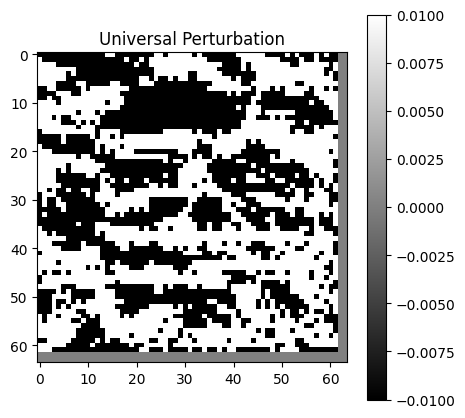

In [33]:
universal_perturbation = X_test_up - X_test

# visualize the universal perturbation
plt.figure(figsize=(5, 5))
plt.title('Universal Perturbation')
plt.imshow(universal_perturbation[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()
